# ATMS 523 Weather and Climate Data Analytics
## Project 2: dask & xarray for computing weather and climate diagnostics
#### Erin Welch

In [77]:
# Import and load required packages
import os
import datetime as dt
from pathlib import Path
import gcsfs

import numpy as np
import pandas as pd
import xarray as xr

from dask.distributed import Client, progress
import dask

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [78]:
# Set up local cluster
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56897,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:56912,Total threads: 2
Dashboard: http://127.0.0.1:56916/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:56900,


2025-09-30 10:06:50,912 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/Users/erinwelch/Desktop/ATMS 523/Module 2/ATMS-523-Module-2-Welch/.conda/lib/python3.13/site-packages/tornado/websocket.py", line 965, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/Users/erinwelch/Desktop/ATMS 523/Module 2/ATMS-523-Module-2-Welch/.conda/lib/python3.13/site-packages/tornado/web.py", line 3375, in wrapper
    return method(self, *args, **kwargs)
  File "/Users/erinwelch/Desktop/ATMS 523/Module 2/ATMS-523-Module-2-Welch/.conda/lib/python3.13/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired. Configure the app with a larger value for --session-token-expiration if necessary")
bokeh.protocol.e

### (1) Use the precipitation output of ERA-5 to compute a time series of daily precipitation at a given point closest to a city of your choosing. Choose a box of 5 x 5 deg lat-lon values over the grid box closest to the city you are examining.  Save this data.  Use a period of at least 10 years.

Use Zarr to access ERA-5 data. More info can be found here: https://github.com/google-research/arco-era5

In [79]:
# Load daily ERA-5 precip using Zarr
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
    consolidated=True
)

# Subset data from 2011 to 2020
total_precip = ds['total_precipitation'].sel(time=slice('2011-01-01', '2020-12-31'))

# Print to visualize precipitation data subset
total_precip

<xarray.DataArray 'total_precipitation' (time: 87672, latitude: 721,
                                         longitude: 1440)> Size: 364GB
[91024577280 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 701kB 2011-01-01 ... 2020-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [73]:
# Specify coordinates for city of interest (Minneapolis, MN)
lat, lon = 44.98, -93.27 + 360 # add 360 to convert longitude

# Subset to 5x5 degree box
pcp_box = total_precip.sel(latitude=slice(lat+2.5, lat-2.5), 
                           longitude=slice(lat-2.5, lat+2.5))

# Print spatially subset data
pcp_box

<xarray.DataArray 'total_precipitation' (time: 87672, latitude: 20,
                                         longitude: 20)> Size: 140MB
[35068800 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 80B 47.25 47.0 46.75 46.5 ... 43.0 42.75 42.5
  * longitude  (longitude) float32 80B 42.5 42.75 43.0 ... 46.75 47.0 47.25
  * time       (time) datetime64[ns] 701kB 2011-01-01 ... 2020-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m

In [80]:
# Take the average precip across the 5x5 box
pcp_box_avg = pcp_box.mean(dim=['latitude', 'longitude'])

In [81]:
pcp_box_avg

<xarray.DataArray 'total_precipitation' (time: 87672)> Size: 351kB
array([2.0701617e-04, 2.1728533e-04, 2.4038472e-04, ..., 2.1388154e-05,
       2.6806854e-05, 2.4418723e-05], shape=(87672,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 701kB 2011-01-01 ... 2020-12-31T23:00:00

In [82]:
# Resample to get daily precipitation totals and convert from m to mm
pcp_daily = pcp_box_avg.resample(time='1D').sum().compute() * 1000

In [83]:
pcp_daily

<xarray.DataArray 'total_precipitation' (time: 3653)> Size: 15kB
array([3.2866724 , 0.03338708, 0.01613979, ..., 0.3234159 , 0.24941197,
       0.47524852], shape=(3653,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2011-01-01 2011-01-02 ... 2020-12-31

Text(0.5, 1.0, 'Daily Precipitation near Minneapolis, MN')

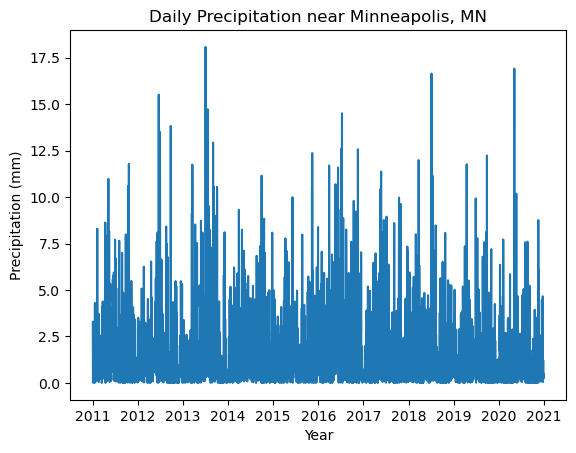

In [84]:
# Plot precipitation time series
plt.plot(pcp_daily.time, pcp_daily.values)
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation near Minneapolis, MN')

In [85]:
# Save time series netcdf file to complete part 1 
pcp_daily.to_netcdf('Module2_part1.nc')

### (2) Determine the 95% values of daily precipitation for the data created in (1).  Plot a *cumulative distribution function* of all values daily precipitation values and illustrate the 95% value of daily precipitation in millimeters.

In [86]:
# Calculate and print the 95th percentile of daily precipitation near Minneapolis, MN
pcp_95 = np.percentile(pcp_daily.values, 95)
print(pcp_95)

5.701997


In [87]:
# Construct CDF
pcp_sorted = np.sort(pcp_daily.values)
cdf = np.arange(1, len(pcp_sorted)+1) / len(pcp_sorted)

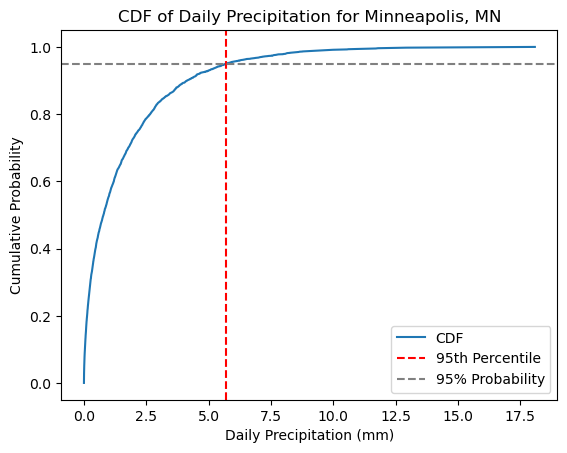

In [88]:
# Plot CDF with 95th percentile
plt.plot(pcp_sorted, cdf, label='CDF')
plt.axvline(pcp_95, color='red', linestyle='--', label='95th Percentile')
plt.axhline(0.95, color='gray', linestyle='--', label='95% Probability')
plt.xlabel("Daily Precipitation (mm)")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Daily Precipitation for Minneapolis, MN")
plt.legend()
plt.show()

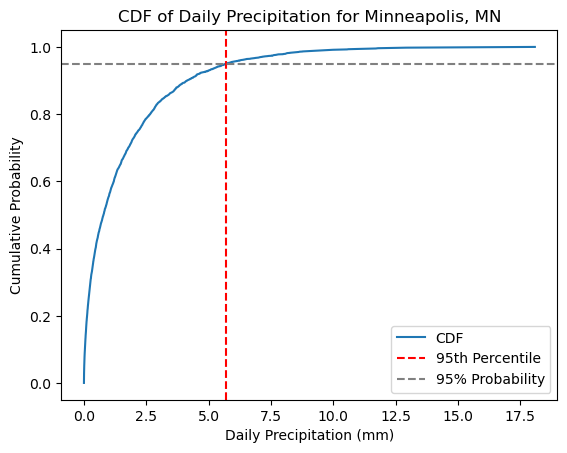

In [ ]:
# Plot CDF with 95th percentile
plt.plot(pcp_sorted, cdf, label='CDF')
plt.axvline(pcp_95, color='red', linestyle='--', label='95th Percentile')
plt.axhline(0.95, color='gray', linestyle='--', label='95% Probability')
plt.xlabel("Daily Precipitation (mm)")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Daily Precipitation for Minneapolis, MN")
plt.legend()
plt.show()

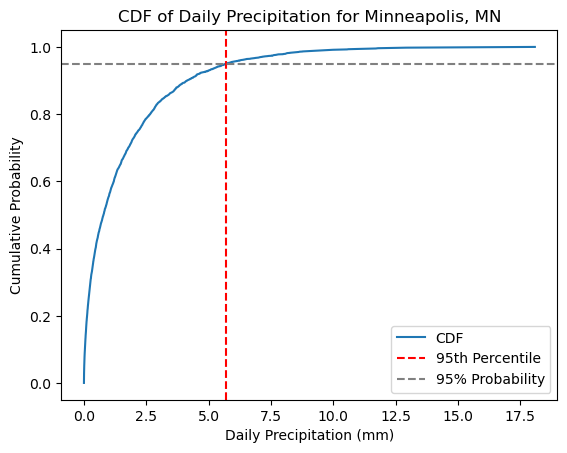

In [ ]:
# Plot CDF with 95th percentile
plt.plot(pcp_sorted, cdf, label='CDF')
plt.axvline(pcp_95, color='red', linestyle='--', label='95th Percentile')
plt.axhline(0.95, color='gray', linestyle='--', label='95% Probability')
plt.xlabel("Daily Precipitation (mm)")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Daily Precipitation for Minneapolis, MN")
plt.legend()
plt.show()

### (3) Create a map of the composite mean precipitation on the 95% days identified in (2) over the continental USA, and a map of the anomaly of precipitation from the 1981-2010 mean. This field should be plotted on a Cartopy map centered at your city with a 40 x 40 degree lat-lon range.

In [98]:
# Itendify extreme precipitation days using the 95th percentile as a threshold
extremes = pcp_daily.time[pcp_daily>pcp_95]

# print out the extremes and number of extreme events
print(len(extremes))
print(extremes)

183
<xarray.DataArray 'time' (time: 183)> Size: 1kB
array(['2011-02-06T00:00:00.000000000', '2011-04-11T00:00:00.000000000',
       '2011-04-12T00:00:00.000000000', '2011-04-13T00:00:00.000000000',
       '2011-04-20T00:00:00.000000000', '2011-05-06T00:00:00.000000000',
       '2011-05-07T00:00:00.000000000', '2011-05-13T00:00:00.000000000',
       '2011-06-14T00:00:00.000000000', '2011-06-20T00:00:00.000000000',
       '2011-06-30T00:00:00.000000000', '2011-07-03T00:00:00.000000000',
       '2011-08-03T00:00:00.000000000', '2011-08-26T00:00:00.000000000',
       '2011-09-25T00:00:00.000000000', '2011-10-02T00:00:00.000000000',
       '2011-10-13T00:00:00.000000000', '2011-10-19T00:00:00.000000000',
       '2011-10-20T00:00:00.000000000', '2012-02-18T00:00:00.000000000',
       '2012-04-17T00:00:00.000000000', '2012-06-01T00:00:00.000000000',
       '2012-06-08T00:00:00.000000000', '2012-06-16T00:00:00.000000000',
       '2012-06-17T00:00:00.000000000', '2012-06-18T00:00:00.000000000',

In [99]:
# Specify coordinates for Minneapolis, MN
lat, lon = 44.98, -93.27 + 360  # add 360 to convert longitude

# Define 40x40 degree box
lat_min, lat_max = lat - 20, lat + 20
lon_min, lon_max = lon - 20, lon + 20

# Subset data to 40x40 degree box around Minneapolis
pcp_box40 = total_precip.sel(latitude=slice(lat_max, lat_min), 
                             longitude=slice(lon_min, lon_max))

# Print
print(pcp_box40)

<xarray.DataArray 'total_precipitation' (time: 87672, latitude: 160,
                                         longitude: 160)> Size: 9GB
[2244403200 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 640B 64.75 64.5 64.25 64.0 ... 25.5 25.25 25.0
  * longitude  (longitude) float32 640B 246.8 247.0 247.2 ... 286.0 286.2 286.5
  * time       (time) datetime64[ns] 701kB 2011-01-01 ... 2020-12-31T23:00:00
Attributes:
    long_name:   Total precipitation
    short_name:  tp
    units:       m


In [100]:
# Calculate composite mean precipitation on extreme days
composite_precip = pcp_box40.sel(time=extremes).mean(dim='time') * 1000

In [102]:
# Calculate the 1981-2010 climatology for the same 40x40 box
climo_hist = ds['total_precipitation'].sel(
    time=slice('1981-01-01', '2010-12-31'),
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max)
).resample(time='1D').sum().mean(dim='time') * 1000

In [ ]:
# Calculate precipitation anomaly by subtracting the climatology over 1981-2010 from the composie precipitation
anomaly_pcp = composite_precip - climo_hist

In [114]:
# Convert latitude and longitude for plotting function

# Define converting function
def to_180(lon):
    return ((lon + 180) % 360) - 180

# Apply function to all datasets used for plotting
pcp_box40 = pcp_box40.assign_coords(longitude=to_180(pcp_box40.longitude))
composite_precip = composite_precip.assign_coords(longitude=to_180(composite_precip.longitude))
anomaly_pcp = anomaly_pcp.assign_coords(longitude=to_180(anomaly_pcp.longitude))

/Users/erinwelch/Desktop/ATMS 523/Module 2/ATMS-523-Module-2-Welch/.conda/lib/python3.13/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/erinwelch/Desktop/ATMS 523/Module 2/ATMS-523-Module-2-Welch/.conda/lib/python3.13/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/erinwelch/Desktop/ATMS 523/Module 2/ATMS-523-Module-2-Welch/.conda/lib/python3.13/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/Users/erinwelch/Desktop/ATMS 523/Module 2/ATMS-523-Module-2-Welch/.conda/lib/python3.13/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return

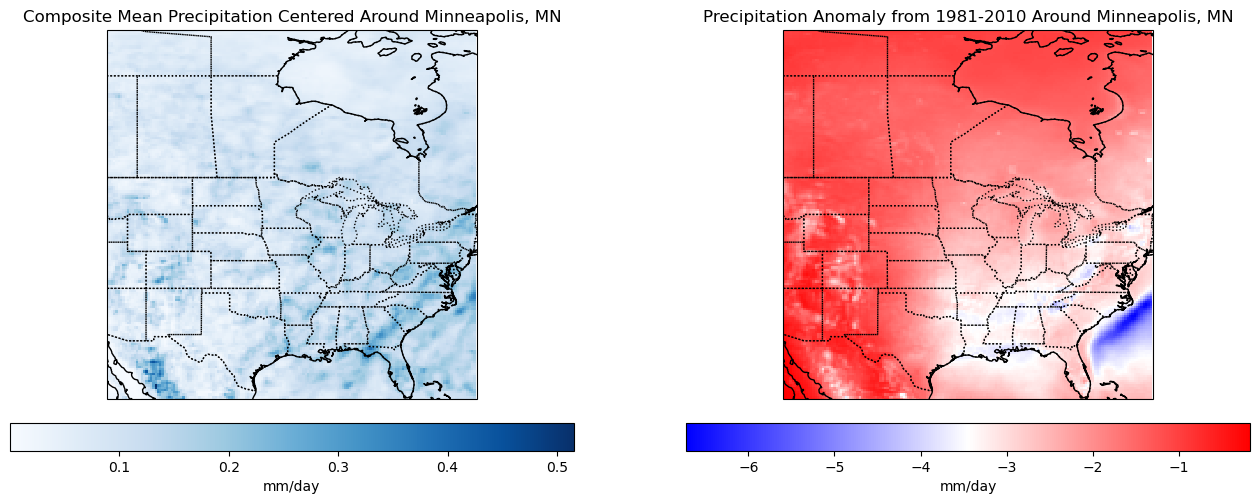

In [118]:
# PLOT Cartopy Map

# Specify projection and set extent for 40x40 box around Minneapolis
proj = ccrs.PlateCarree()

# Reset extent using -180–180
lon_center = -93.27
lat_center = 44.98
extent = [lon_center - 20, lon_center + 20, lat_center - 20, lat_center + 20]

# Create 2 panel figure
fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection':proj})

# Plot composite mean
comp_plot = axs[0].pcolormesh(composite_precip.longitude, composite_precip.latitude, 
                              composite_precip, cmap = 'Blues', transform = proj)
axs[0].set_title('Composite Mean Precipitation Centered Around Minneapolis, MN')
axs[0].set_extent(extent, crs=proj)
axs[0].add_feature(cfeature.COASTLINE)
axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].add_feature(cfeature.STATES, linestyle=':')

# Create colorbar for composite map
comp_cbar = plt.colorbar(comp_plot, ax=axs[0], orientation='horizontal', pad=0.05)
comp_cbar.set_label('mm/day')

# Plot anomaly map
anom_plot = axs[1].pcolormesh(anomaly_pcp.longitude, anomaly_pcp.latitude, 
                              anomaly_pcp, cmap='bwr', transform=proj)
axs[1].set_title('Precipitation Anomaly from 1981-2010 Around Minneapolis, MN')
axs[1].set_extent(extent, crs=proj)
axs[1].add_feature(cfeature.COASTLINE)
axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].add_feature(cfeature.STATES, linestyle=':')

# Create colorbar for anomaly map
anom_cbar = plt.colorbar(anom_plot, ax=axs[1], orientation='horizontal', pad=0.05)
anom_cbar.set_label('mm/day')

In [ ]:
# Close Dask
client.close()